# Numerical potential: Siegert states

The present notebook introduces how to find the Siegert states of a numerical Hamiltonian using `SiegPy`. We still will focus on the 1D Square-Well Potential (1DSWP) case, for comparisons with analytical results to be possible. It is very similar to finding the numerical bound and continuum states, as presented in a previous notebook: the main difference is the use of another coordinate mapping.

## Initialization

Again, the initialization consists in importing some useful classes and modules and defining a potential.

### Import classes and modules

The only modification with respect to the similar notebook where we presented is the use of a different coordinate mapping, namely `ErfKGCoordMap` instead of `UniformCoordMap`. For now, it is enough to say that this type of coordinate mapping is more efficient in finding Siegert states.

In [1]:
from siegpy import (SWPotential, SWPBasisSet, BasisSet,
                    Hamiltonian, ErfKGCoordMap)
# We also import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

### Define a potential

We use the same potential as in the previous notebook.

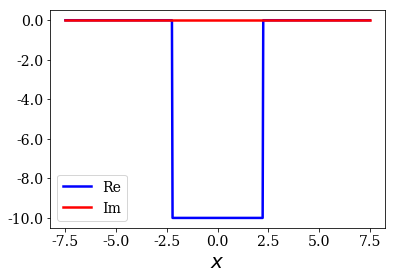

In [2]:
# Read the analytical basis set made of Siegert states
siegerts = SWPBasisSet.from_file("siegerts.dat")

# Find its potential, and discretize it over a grid
pot = siegerts.potential
l = pot.width
xmax = 7.5
xgrid = np.linspace(-xmax, xmax, 501)
pot.grid = xgrid
pot.plot()

## Finding numerical eigenstates

Finding numerical Siegert states of a Hamiltonian is done in the same manner as in the previous notebook, namely:

* first, a `Hamiltonian` is defined in matrix form, 

* and then its eigenvalues and eigenvectors are found in order to create a `BasisSet` instance.

### Define the Hamitonian

As pointed earlier, the main modification in this notebook is the use of another type of complex scaling. Instead of simply using a uniform complex scaling of the space variable ($x \mapsto x e^{i \theta}$, with $\theta > 0$), it has been shown that using a (smooth) exterior complex scaling is a better solution to find high quality numerical Siegert states. The idea is simple: an inner region is left unscaled, while the complex scaling is (smoothly) turned on the farthest regions. This also has the advantage of leaving the inner potential unscaled.

The coordinate mapping `ErfKGCoordMap` used in this notebook is one of the many is a coordinate mapping of the type $x \mapsto (x \pm x_0) e^{i \theta g(x)} \mp x_0$, with $g$ being a function smoothly going from 0 to 1 around $\mp x_0$. In this case, $g: x \mapsto 1 + \frac{1}{2} \left[ \text{erf}(\lambda (x-x_0)) - \text{erf}(\lambda (x+x_0))\right]$. 

Other types of smooth exterior coordinate mappings provided in the SiegPy module are `TanhKGCoordMap`, `ErfSimonCoordMap` and `TanhSimonCoordMap` (see SiegPy documentation for more details).

In [3]:
# Initialize a coordinate mapping
x0 = 6.0
lbda = 1.5
cm = ErfKGCoordMap(0.6, x0, lbda)

# Initialize the Hamiltonian with the potential and the coordinate mapping
ham = Hamiltonian(pot, cm)

### Solving the Hamiltonian

For the moment, nothing new here: you can easily solve the Hamiltonian to create a basis set:

In [4]:
basis = ham.solve()

You can then plot the energies, wavenumbers and wavefunctions as usual:

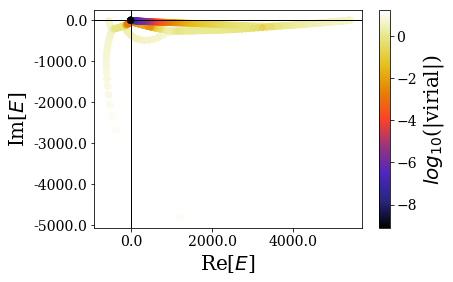

In [5]:
basis.plot_energies()

The spectrum is more complex, but, as you can see, there are lots of states that have a low virial value. They are located near the origin. By zooming in, we get the following picture:

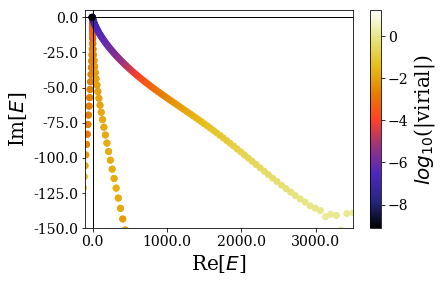

In [6]:
basis.plot_energies(xlim=(-100, 3500), ylim=(-150, 5))

The states with the lowest virial seem to be bound and resonant states. This is confirmed by zooming in even more closely:

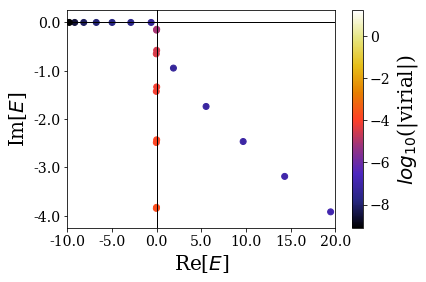

In [7]:
basis.plot_energies(xlim=(-10, 20), ylim=(-4.25, 0.25))

However, if you would plot the wavefunctions by limiting the number of resonant states via the `nres` optional argument (as usual), you would get nothing:

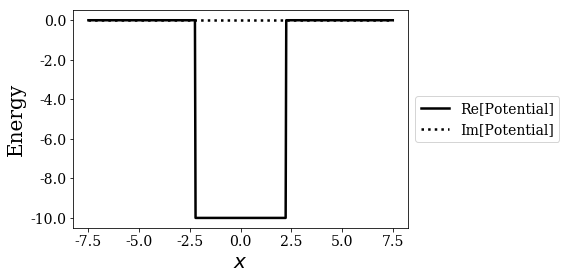

In [8]:
basis.plot_wavefunctions(nres=2)

This is because we did not provide a maximal virial value to sort between the Siegert states and the rest of the eigenvalues: all states have an unknwon type:

In [9]:
len(basis.unknown)

501

In this case, it is possible to specify the `nstates` optional argument, that plots the first states of the basis set (*i.e.* those of lowest virial):

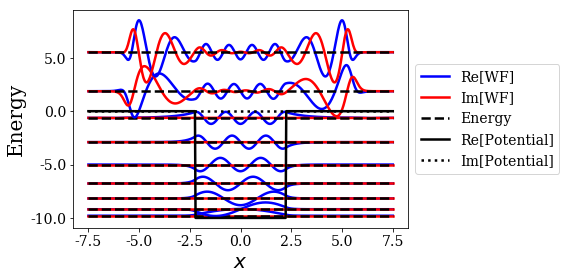

In [10]:
basis.plot_wavefunctions(nstates=9)

The states with the lowest virial values correspond to bound and resonant states of lowest energies in this basis set (but it might not always be the case, especially if the grid is not dense enough or if the coordinate mapping parameters are not well chosen). Note that the resonant states wavefunctions tend to zero on the edges of the simulation box: this is due to the smooth exterior complex scaling, that compensates for the diverging wavefunctions, making the numerical resonant states square integrable.

### Solving the Hamiltonian: virial filtering

We saw that the Siegert states have the lowest virial values in the basis set. It might therefore be interesting to define a maximal virial to sort the Siegert states from the rest of the states (of unknown type). This can be set while solving the Hamiltonian by providing a postive value to the `max_virial` argument:

In [11]:
basis_filtered = ham.solve(max_virial=3*10**(-6))

This allows to separate bound and resonant states from the rest of the states:

In [12]:
len(basis_filtered.bounds), len(basis_filtered.resonants), len(basis_filtered.unknown)

(7, 30, 464)

The plot of the wavenumbers or energies then only represents the Siegert states if the `show_unknown` optional argument is set to `False`:

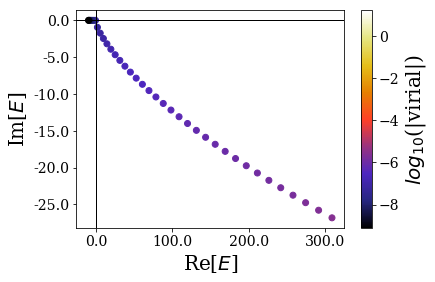

In [13]:
basis_filtered.plot_energies(show_unknown=False)

To plot all the other states, you must set the optional argument `show_unknown` of `plot_energies` or `plot_wavenumbers` to `True`.

Regarding the `plot_wavefunctions`, using the `nres` optional argument gives the expected result:

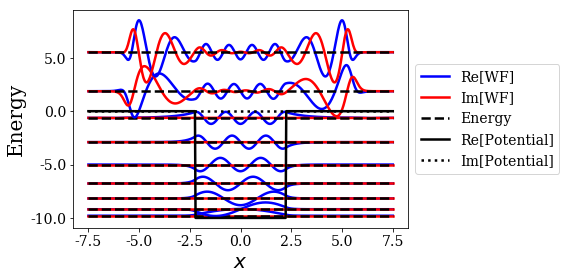

In [14]:
basis_filtered.plot_wavefunctions(nres=2)

## Comparison of the numerical Siegert states with the analytical ones

Only bound and resonant states were found with the current complex scaling (*i.e.*, the anti-bound and anti-resonant states are missing), and we will compare their wavefunctions and energies with those of the analytical ones.

### Bound states

Let us first compare the numerical bound states to the analytical ones:

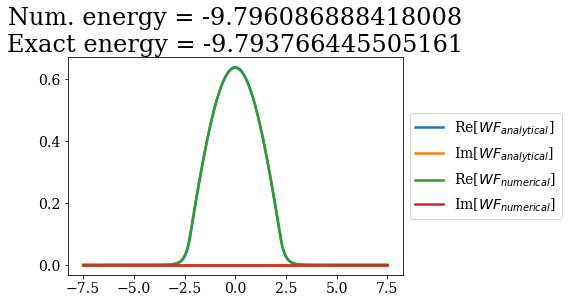

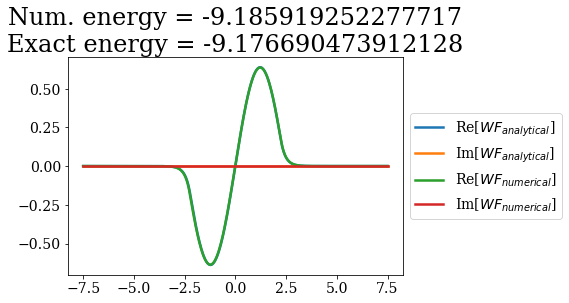

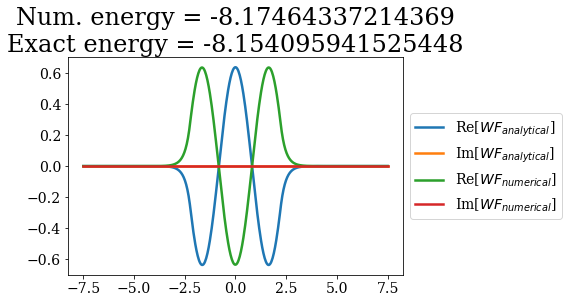

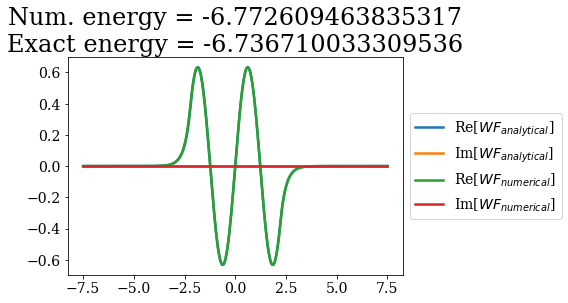

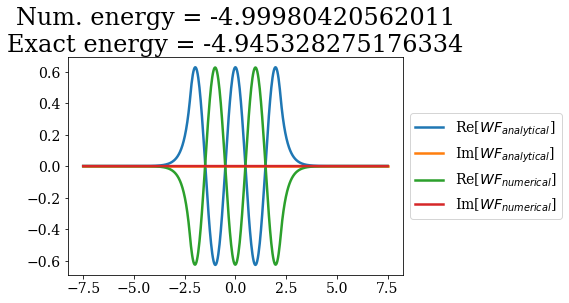

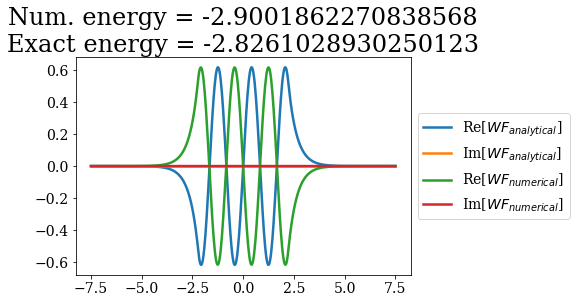

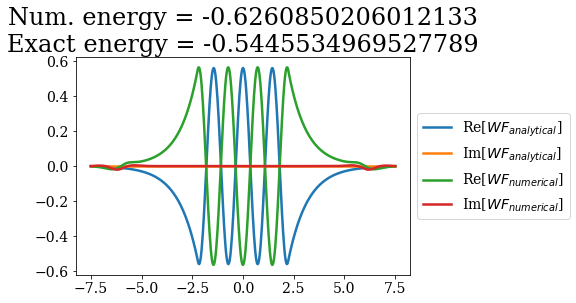

In [15]:
# Discretize the analytical siegert states over the same grid as the numerical ones
siegerts.grid = xgrid
# Plot the anaytical and numerical bound states
for i in range(7):
    analytical_bnd = siegerts.bounds[i]
    numerical_bnd = basis_filtered.bounds[i]
    title = "Num. energy = {0.real}\nExact energy = {1.real}"\
            .format(numerical_bnd.energy, analytical_bnd.energy)
    plt.plot(analytical_bnd.grid, np.real(analytical_bnd.values), label="Re[$WF_{analytical}$]")
    plt.plot(analytical_bnd.grid, np.imag(analytical_bnd.values), label="Im[$WF_{analytical}$]")
    plt.plot(numerical_bnd.grid,np.real(numerical_bnd.values), label="Re[$WF_{numerical}$]")
    plt.plot(numerical_bnd.grid,np.imag(numerical_bnd.values), label="Im[$WF_{numerical}$]")
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()

The energies are almost the same as the ones obtained numerically in the previous notebook (without a coordinate mapping), the main difference occuring for the bound state of highest energy: this state exhibits a longer expontential tail, that is affected by the smooth exterior coordinate mapping. This is actually the case for all the other state, but the lower the bound state energy (*i.e.* the smaller the exponential tail), the smaller the influence of the coordinate mapping.

### Resonant states

The resonant states obtained can also be compared to the analytical resonant states:

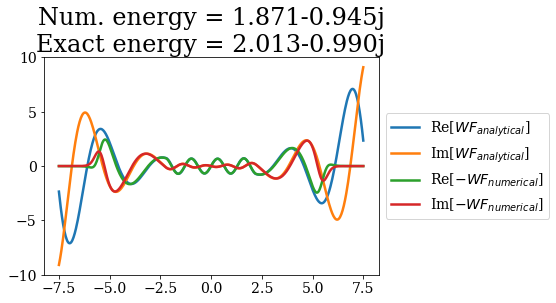

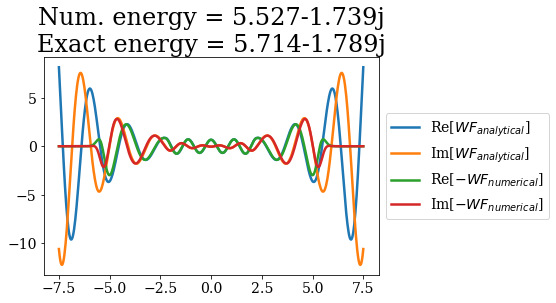

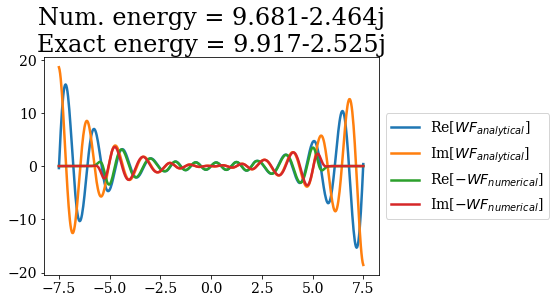

In [16]:
# Loop over the first three resonant states
for i in range(3):
    analytical_res = siegerts.resonants[i]
    numerical_res = basis_filtered.resonants[i]
    title = "Num. energy = {0:.3f}\nExact energy = {1:.3f}"\
            .format(numerical_res.energy, analytical_res.energy)
    plt.plot(analytical_res.grid, np.real(analytical_res.values), label="Re[$WF_{analytical}$]")
    plt.plot(analytical_res.grid, np.imag(analytical_res.values), label="Im[$WF_{analytical}$]")
    plt.plot(numerical_res.grid, -np.real(numerical_res.values), label="Re[$- WF_{numerical}$]")
    plt.plot(numerical_res.grid, -np.imag(numerical_res.values), label="Im[$- WF_{numerical}$]")
    plt.title(title)
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.show()

The wavefunctions of the numerical resonants states are the same as the analytical ones (save for an unrelevant minus sign): their shape and normalization are well reproduced in the unscaled region. The main differences come from the energies, even though they are consistent with the analytical results, and the exponential divergence of the wavefunction, that is "absorbed" by the coordinate mapping.

## Conclusion

This notebook presented how to find numerical Siegert states (namely, bound and resonant states). This was possible thanks to the application of a smooth exterior complex mapping. The expectation value of the virial operator has been presented as an important quantity allowing to separate numerical Siegert states from the rest of the numerical eigenstates. It was shown that the bound and resonant states found numerically are comparable to the analytical ones (in terms of energy and wavefunction, including their normalization).